In [2]:
import numpy as np
import pandas as pd
import os
from PIL import Image, ImageDraw, ImageFont, ImageOps
import matplotlib.pyplot as plt
import seaborn as sns
import re
from shutil import copy2
import cv2

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.preprocessing import image as k_image
from tensorflow.keras.callbacks import ModelCheckpoint
import pocketsphinx

Total data gambar: 13440
Shape setiap gambar: (224, 224)


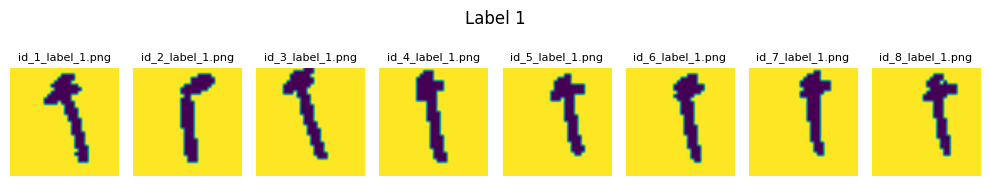

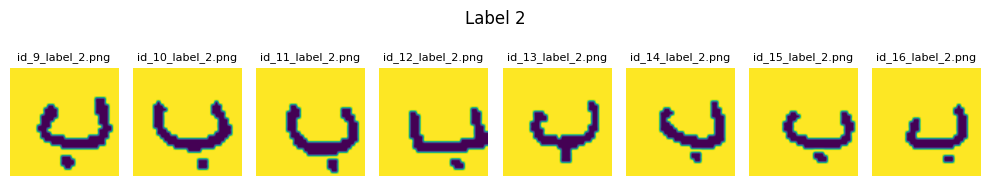

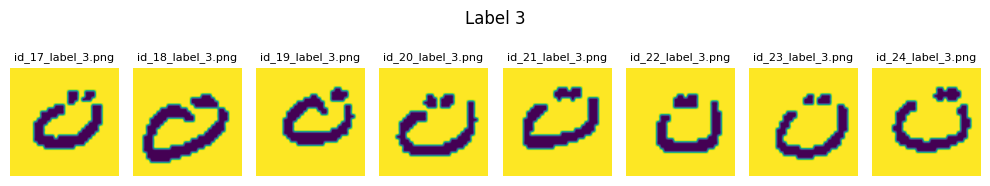

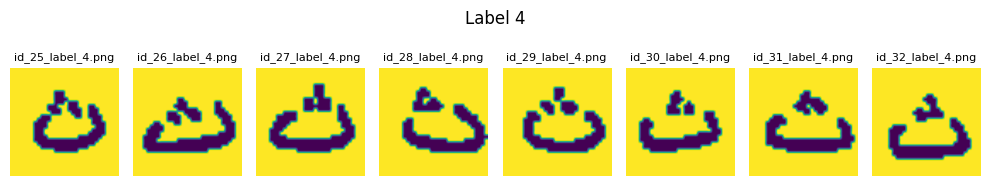

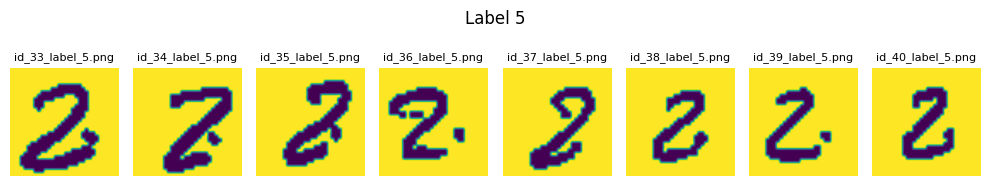

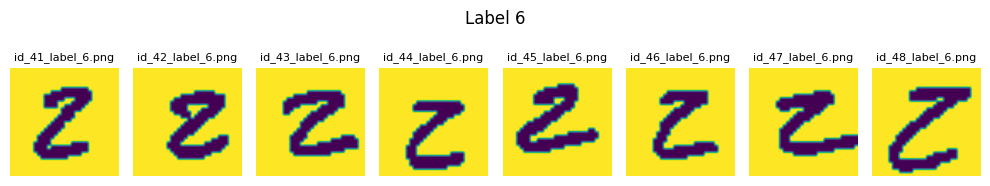

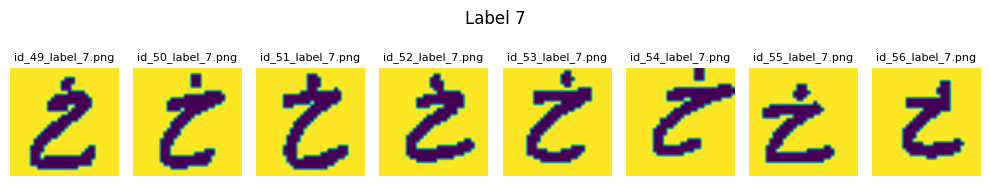

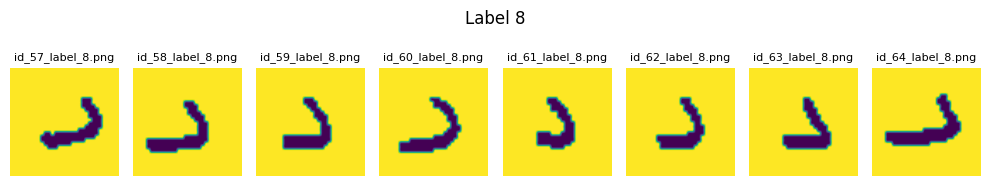

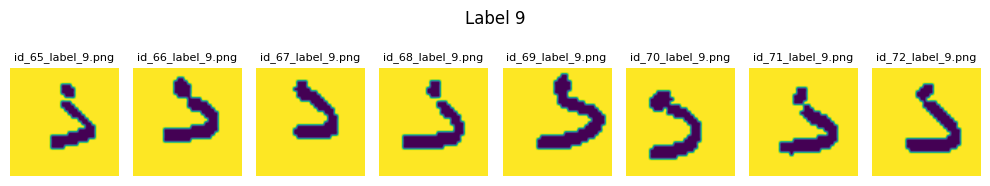

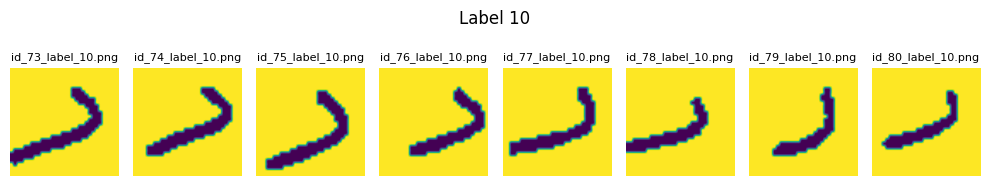

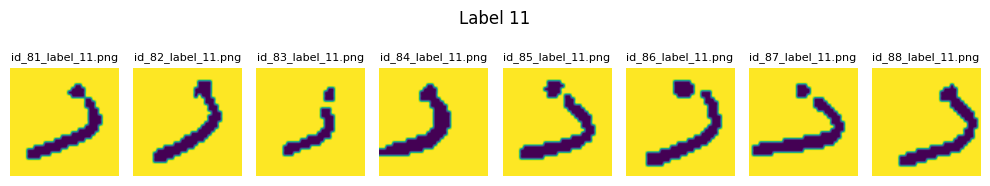

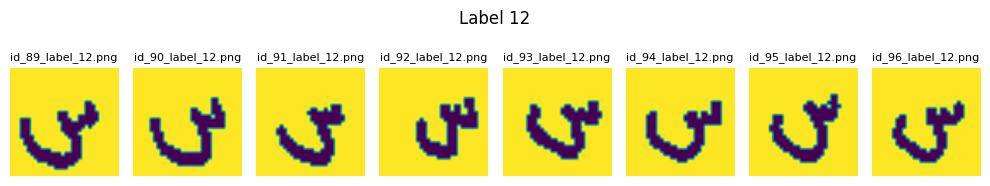

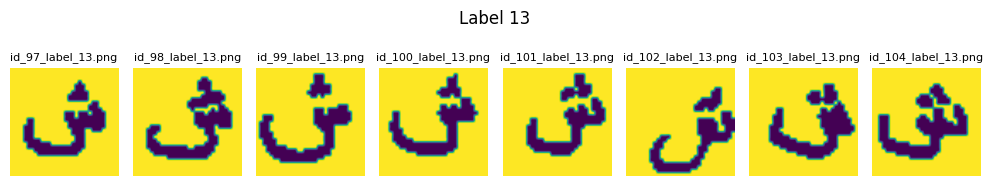

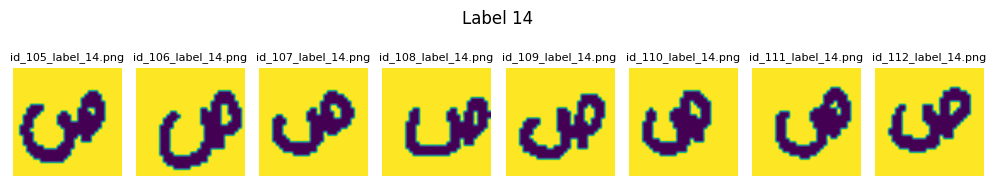

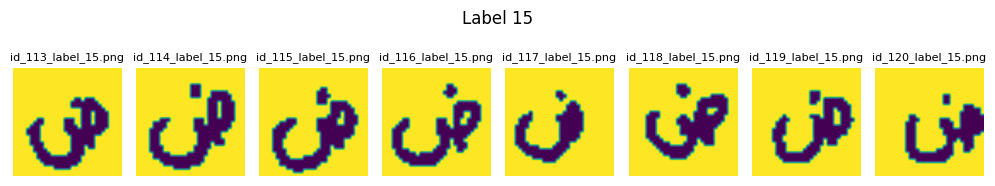

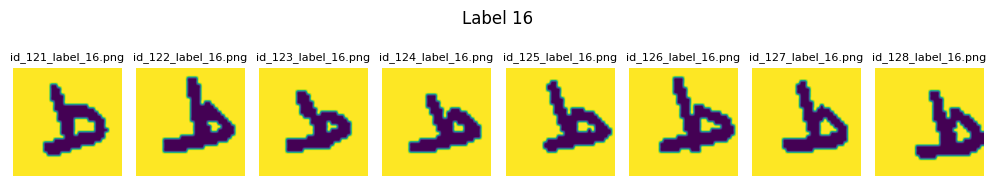

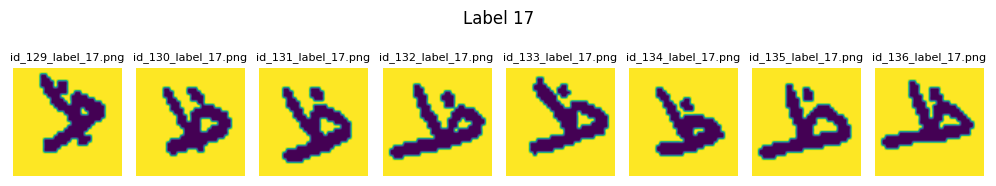

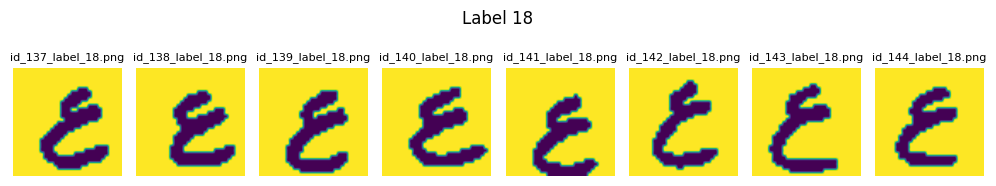

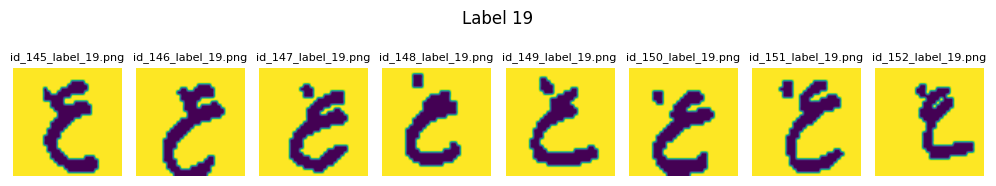

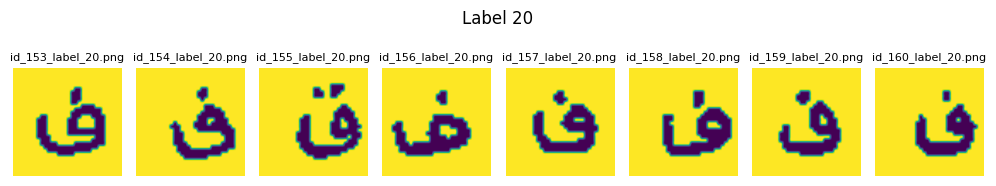

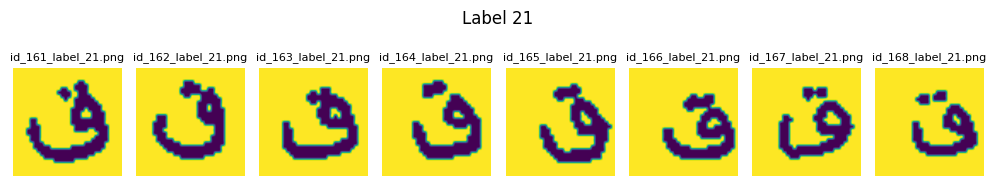

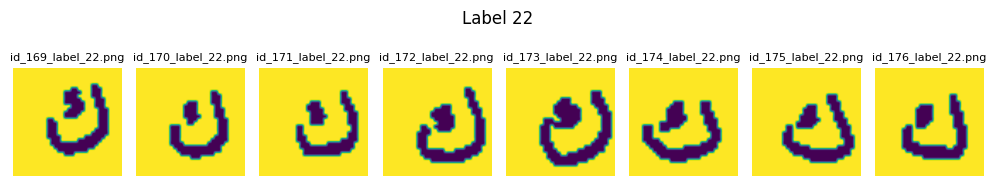

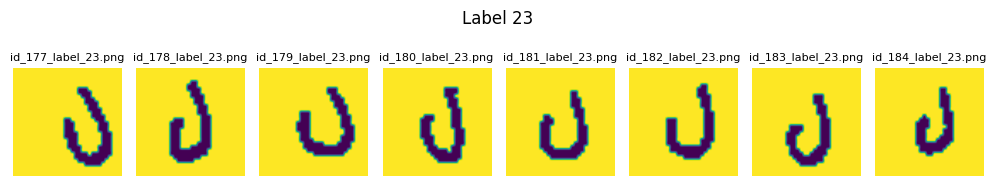

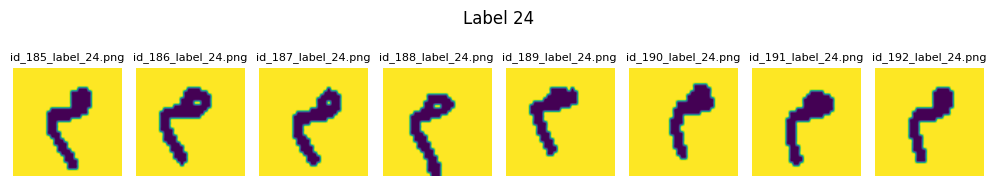

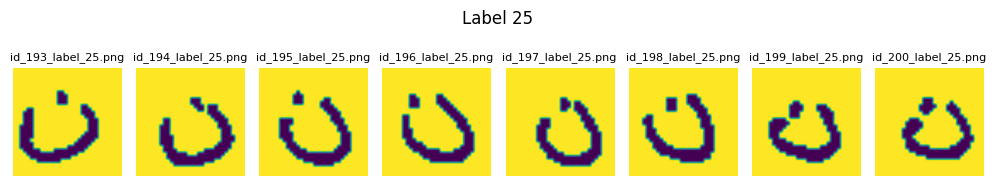

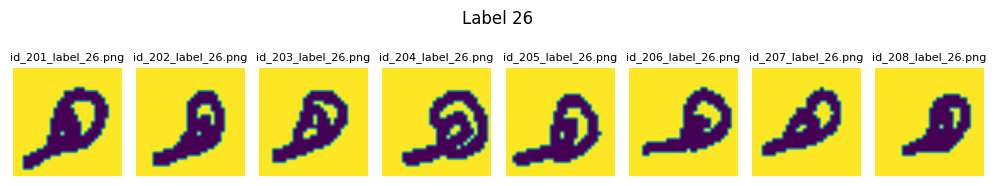

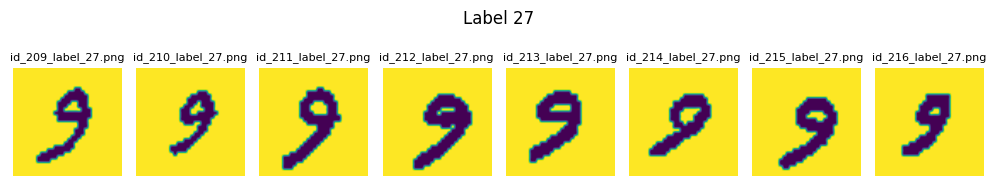

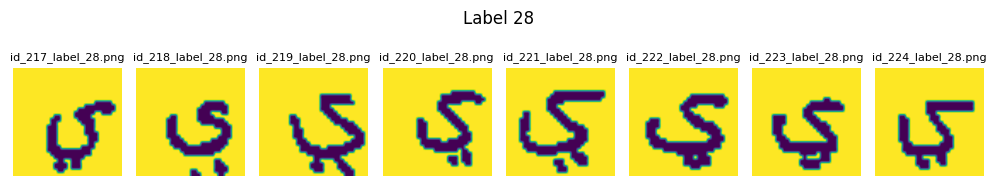

In [5]:
source_folder = r"C:\Users\gagah\Desktop\KKN\data\Train Images 13440x32x32\train"
size = 224

images_with_filenames = []

def extract_id(filename):
    match = re.search(r'id_(\d+)_', filename)
    return int(match.group(1)) if match else -1

file_list = [f for f in os.listdir(source_folder) if f.endswith(".png")]
file_list.sort(key=extract_id)

for filename in file_list:
    img_path = os.path.join(source_folder, filename)
    img = Image.open(img_path) 
    img = ImageOps.invert(img)#.convert('L')
    img = img.resize((size, size))
    img_array = np.array(img)
    images_with_filenames.append((img_array, filename))

images = np.array([img[0] for img in images_with_filenames])
filenames = [img[1] for img in images_with_filenames]

print(f'Total data gambar: {len(images)}')
print(f'Shape setiap gambar: {images[0].shape}')


# Memunculkan gambar
# Memisahkan gambar berdasarkan label
label_dict = {}
for img_array, filename in images_with_filenames:
    match = re.search(r'label_(\d+)', filename)
    if match:
        label = int(match.group(1))
        if label not in label_dict:
            label_dict[label] = []
        label_dict[label].append((img_array, filename))

# Menampilkan gambar per label
for label, images in label_dict.items():
    fig, axes = plt.subplots(1, 8, figsize=(10, 2))
    axes = axes.ravel()
    for i in range(min(8, len(images))):
        axes[i].imshow(images[i][0])
        axes[i].axis('off')
        axes[i].set_title(images[i][1], fontsize=8)
    plt.suptitle(f'Label {label}')
    plt.tight_layout()
    plt.show()

In [6]:

def adjust_text_color(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hue_shift = np.random.uniform(-10, 10)
    saturation_shift = np.random.uniform(0.5, 1.5)
    value_shift = np.random.uniform(0.5, 1.5)
    hsv_image[..., 0] = (hsv_image[..., 0] + hue_shift) % 180
    hsv_image[..., 1] = np.clip(hsv_image[..., 1] * saturation_shift, 0, 255)
    hsv_image[..., 2] = np.clip(hsv_image[..., 2] * value_shift, 0, 255)
    adjusted_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)
    return adjusted_image

def adjust_brightness_contrast(image):
    brightness = np.random.uniform(0.5, 1.5)
    contrast = np.random.uniform(0.5, 1.5)
    adjusted_image = cv2.convertScaleAbs(image, alpha=contrast, beta=brightness)
    return adjusted_image

def generate_random_background(image_shape):
    background_color = np.random.randint(0, 256, size=3).tolist()
    background = np.full((image_shape[0], image_shape[1], 3), background_color, dtype=np.uint8)
    return background

def apply_background_color(image):
    background = generate_random_background(image.shape)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(gray_image, 1, 255, cv2.THRESH_BINARY)
    binary_mask_3ch = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2BGR)
    combined_image = np.where(binary_mask_3ch == 255, image, background)
    return combined_image

def augment_image(image):
    image = adjust_text_color(image)
    image = adjust_brightness_contrast(image)
    image = apply_background_color(image)
    return image

# Create custom image generator
def custom_image_generator(directory, target_size, batch_size, color_mode='rgb'):
    datagen = ImageDataGenerator(
        preprocessing_function=lambda x: augment_image(k_image.img_to_array(x))
    )
    generator = datagen.flow_from_directory(
        directory=directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode=color_mode
    )
    return generator

# Set directories and parameters
TRAINING_DIR = "data/Data_Train_Images"

model_dir = 'model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Define callbacks
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.90 and logs.get('val_accuracy') > 0.90:
            print("\nReached 90% accuracy so cancelling training!")
            print(f"accuracy : {logs.get('accuracy') * 100:.2f}% \n"
                  f"val_acc : {logs.get('val_accuracy') * 100:.2f}% \n")
            self.model.stop_training = True

checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(model_dir, 'model_{epoch:02d}_{val_accuracy:.2f}.h5'),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Create data generators
train_generator = custom_image_generator(
    directory=TRAINING_DIR,
    target_size=(size, size),
    batch_size=32,
    color_mode='rgb'
)

validation_generator = custom_image_generator(
    directory=TRAINING_DIR,
    target_size=(size, size),
    batch_size=32,
    color_mode='rgb'
)


Found 13440 images belonging to 28 classes.
Found 13440 images belonging to 28 classes.


In [ ]:

# Define the model using pretrained VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(size, size, 3))
base_model.trainable = False  # Freeze the base model

model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(label_dict.keys()), activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Train the model
model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[checkpoint_callback, myCallback()]
)


421/421 [==============================] - 112s 264ms/step


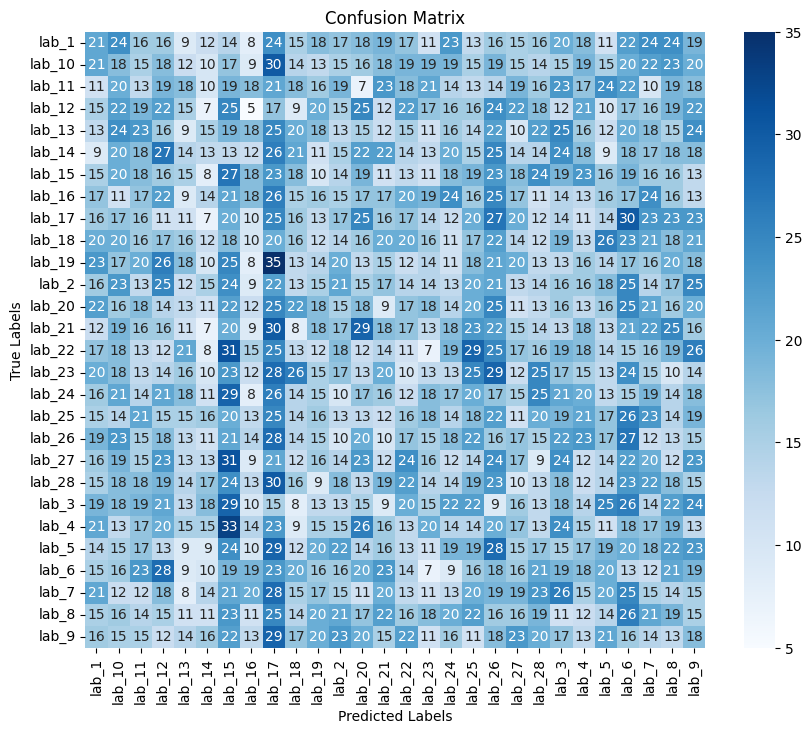

              precision    recall  f1-score   support

       lab_1       0.04      0.04      0.04       480
      lab_10       0.04      0.04      0.04       480
      lab_11       0.03      0.03      0.03       480
      lab_12       0.04      0.05      0.04       480
      lab_13       0.02      0.02      0.02       480
      lab_14       0.04      0.03      0.03       480
      lab_15       0.04      0.06      0.05       480
      lab_16       0.05      0.04      0.04       480
      lab_17       0.04      0.05      0.04       480
      lab_18       0.04      0.03      0.04       480
      lab_19       0.03      0.03      0.03       480
       lab_2       0.05      0.04      0.05       480
      lab_20       0.04      0.04      0.04       480
      lab_21       0.04      0.04      0.04       480
      lab_22       0.02      0.02      0.02       480
      lab_23       0.03      0.03      0.03       480
      lab_24       0.04      0.04      0.04       480
      lab_25       0.04    

In [7]:
model = load_model('model/model_04_0.84.h5')
# Generate predictions on the validation set
validation_generator.reset()
predictions = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))